In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [257]:
plt.rcParams["figure.figsize"] = (10, 10)

def draw_points(points, closest):
    plt.scatter(list(map(lambda x: x[0], points)), list(map(lambda x: x[1], points)), color='c', s=[6] * len(points))
    plt.scatter(list(map(lambda x: x[0], closest)), list(map(lambda x: x[1], closest)), color='r', s=[6] * len(closest))
    plt.show()

In [59]:
from scipy.stats import truncnorm

def uniform_points(n):
    points = []
    for _ in range(n):
        points.append((
          random.uniform(0.0, float(n)),
          random.uniform(0.0, float(n))
        ))

    return points

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [174]:
def center_skewed_points(n, axis):
    points = []
    dist = get_truncated_normal(n // 2, math.sqrt(n), 0, n)
    axis_points = dist.rvs(int(n * 0.7))

    for p in axis_points:
        points.append((
          random.uniform(0.0, float(n)),
          p
        ) if axis == 'y' else (
          p,
          random.uniform(0.0, float(n))
        ))

    for _ in range(0, int(n * 0.3)):
        points.append((
          random.uniform(0.0, float(n)),
          random.uniform(0.0, float(n))
        ))

    return points

In [199]:
def edge_skewed_points(n, axis):
    center_skewed = center_skewed_points(n, axis)
    result = []
    half = n // 2

    for p in center_skewed:
        if axis == 'y':
            result.append(
                (p[0], half - p[1]) if p[1] <= half else (p[0], n - (p[1] - half))
            )
        else:
             result.append(
                (half - p[0], p[1]) if p[0] <= half else (n - (p[0] - half), p[1])
            )
    
    return result

In [237]:
def diagonal_skewed_points(n):
    points = []

    for _ in range(0, int(n * 0.8)):
        x = random.uniform(0.0, float(n))
        y = random.uniform(0.0, n - x)
        points.append((
          x,
          y
        ))

    for _ in range(0, int(n * 0.2)):
        points.append((
          random.uniform(0.0, float(n)),
          random.uniform(0.0, float(n))
        ))
    
    return points

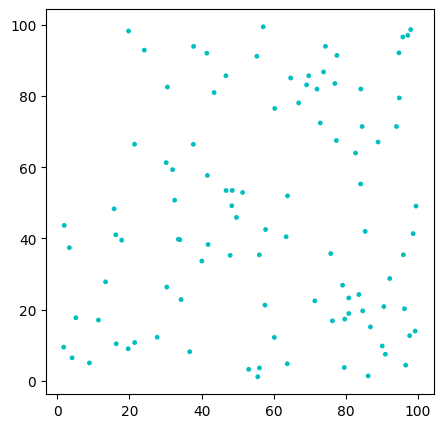

In [238]:
draw_points(uniform_points(100), [])

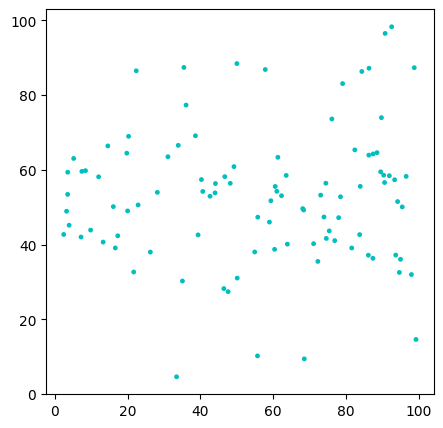

In [239]:
draw_points(center_skewed_points(100, 'y'), [])

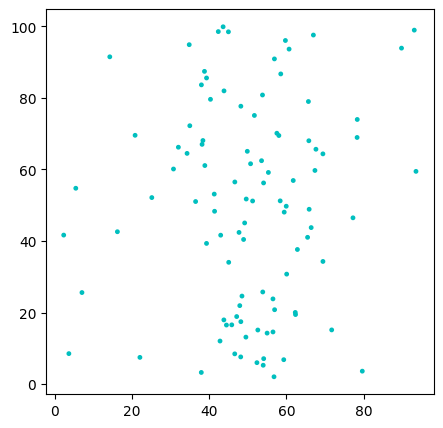

In [240]:
draw_points(center_skewed_points(100, 'x'), [])

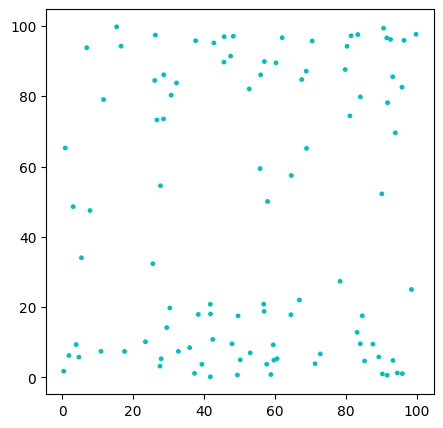

In [241]:
draw_points(edge_skewed_points(100, 'y'), [])

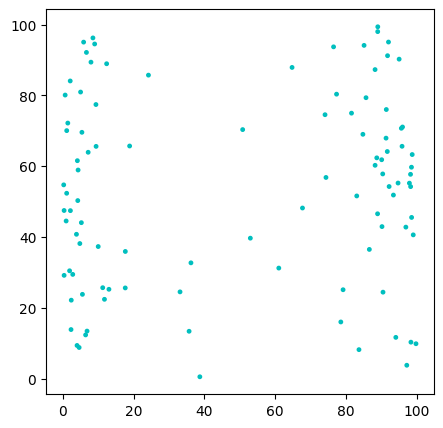

In [242]:
draw_points(edge_skewed_points(100, 'x'), [])

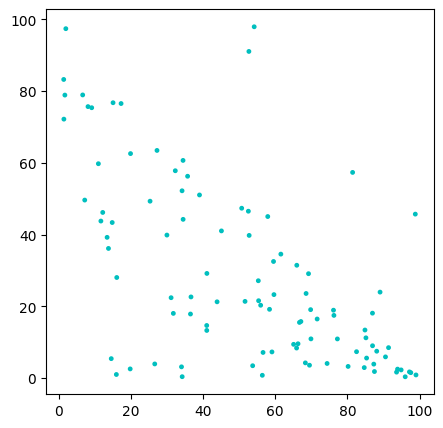

In [243]:
draw_points(diagonal_skewed_points(100), [])

In [204]:
def sort_y(points):
    return sorted(points, key=lambda p: p[1])

def sort_x(points):
    return sorted(points, key=lambda p: p[0])

def dist(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def find_brute_force(points):
    n = len(points)
    res = {'dist': float('inf'), 'points': []}

    ops = 0

    for i in range(0, n):
        for j in range(i + 1, n):
            d = dist(points[i], points[j])
            ops +=1
            if d < res['dist']:
                res = {'dist': d, 'points': (points[i], points[j])}

    return (res, ops)

In [9]:
def _nearest_points(y_sorted, x_sorted):
    n = len(y_sorted)

    if n <= 3:
        return find_brute_force(y_sorted)

    mid_idx = n // 2
    mid_point = y_sorted[mid_idx]

    nearest1, ops1 = _nearest_points(y_sorted[:mid_idx], [p for p in x_sorted if p[1] < mid_point[1]])
    nearest2, ops2 = _nearest_points(y_sorted[mid_idx:], [p for p in x_sorted if p[1] >= mid_point[1]])

    nearest = min([
        nearest1,
        nearest2
    ], key=lambda x: x['dist'])

    candidates = []
    for p in x_sorted:
        if abs(p[1] - mid_point[1]) < nearest['dist']:
            candidates.append(p)

    ops = ops1 + ops2

    # at most this loop has 6 * n/2 iterations
    for i in range(0, len(candidates)):
        for j in range(i + 1, len(candidates)):
            if candidates[j][0] - candidates[i][0] < nearest['dist']:
                d = dist(candidates[i], candidates[j])
                ops += 1
                if d < nearest['dist']:
                    nearest = {'dist': d, 'points': (candidates[i], candidates[j])}

    return (nearest, ops)  

def nearest_points(points):
    return _nearest_points(sort_y(points), sort_x(points))


### Worst case

T(n) = 2T(n/2) + O(n) + O(n) + O(n) = O(nlogn)

### Average case

O(n), because the expected number of points in the strip is O(sqrt(n))

In [157]:
concentration = 0.9

def calc_metrics(observations):
    var =  np.var(observations)
    mean = np.mean(observations)
    dev = np.sqrt(var / (1 - concentration))

    return {
        'mean': mean,
        'var': var,
        'up_bound': mean + dev,
        'low_bound': mean - dev,
        'obsevations': observations
    }

In [244]:
def experiment(max_n=5000, step=10, runs=50):
    point_gens = {
        'uniform': uniform_points,
        'y_center_skewed': lambda n: center_skewed_points(n, 'y'),
        'x_center_skewed': lambda n: center_skewed_points(n, 'x'),
        'y_edge_skewed': lambda n: edge_skewed_points(n, 'y'),
        'x_edge_skewed': lambda n: edge_skewed_points(n, 'x'),
        'diagonal_skewed': diagonal_skewed_points
    }
    
    results = {}

    for n in range(10, max_n, step):
        print(n)
        for dist in point_gens.keys():
            observations = []
            
            for _ in range(runs):
                points = point_gens[dist](n)
                observations.append(nearest_points(points)[1])
            
            if not results.get(dist):
                results[dist] = {}
    
            results[dist][n] = calc_metrics(observations)

    return results

In [246]:
results = experiment(max_n=5000, step=20, runs=50)

10
30
50
70
90
110
130
150
170
190
210
230
250
270
290
310
330
350
370
390
410
430
450
470
490
510
530
550
570
590
610
630
650
670
690
710
730
750
770
790
810
830
850
870
890
910
930
950
970
990
1010
1030
1050
1070
1090
1110
1130
1150
1170
1190
1210
1230
1250
1270
1290
1310
1330
1350
1370
1390
1410
1430
1450
1470
1490
1510
1530
1550
1570
1590
1610
1630
1650
1670
1690
1710
1730
1750
1770
1790
1810
1830
1850
1870
1890
1910
1930
1950
1970
1990
2010
2030
2050
2070
2090
2110
2130
2150
2170
2190
2210
2230
2250
2270
2290
2310
2330
2350
2370
2390
2410
2430
2450
2470
2490
2510
2530
2550
2570
2590
2610
2630
2650
2670
2690
2710
2730
2750
2770
2790
2810
2830
2850
2870
2890
2910
2930
2950
2970
2990
3010
3030
3050
3070
3090
3110
3130
3150
3170
3190
3210
3230
3250
3270
3290
3310
3330
3350
3370
3390
3410
3430
3450
3470
3490
3510
3530
3550
3570
3590
3610
3630
3650
3670
3690
3710
3730
3750
3770
3790
3810
3830
3850
3870
3890
3910
3930
3950
3970
3990
4010
4030
4050
4070
4090
4110
4130
4150
4170
4190
4210


In [272]:
def trend_plot(results):
    ns = list(results.keys())
    means = [results[n]['mean'] for n in ns]
    up_bounds = [results[n]['up_bound'] for n in ns]
    low_bounds = [results[n]['low_bound'] for n in ns]
    n3 = [n * 1.5 for n in ns]
    
    plt.xlabel("Number of points")
    plt.ylabel("Number of checks")
    plt.plot(ns, means, label="Experimental mean")
    plt.plot(ns, ns, label="n", color="green")
    plt.plot(ns, n3, label="1.5*n", color="red")
    plt.plot(ns, up_bounds, label=f"Chebyshev bounds for p = {concentration}", linestyle="--", color="gray")
    plt.plot(ns, low_bounds, label=None, linestyle="--", color="gray")
    plt.legend()
    plt.grid()

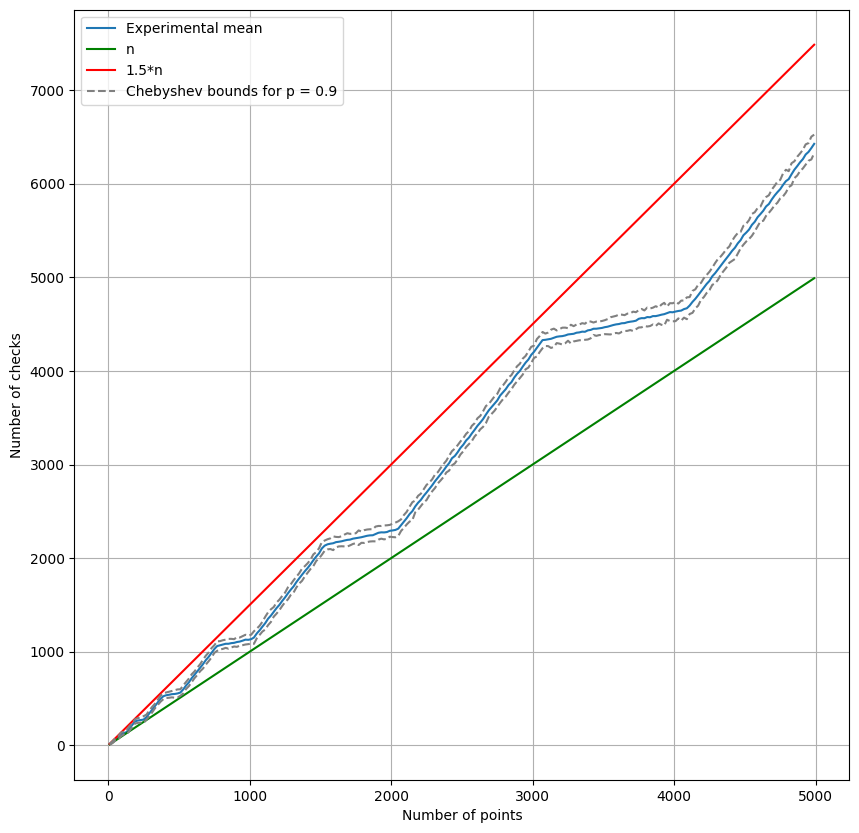

In [273]:
trend_plot(results['uniform'])

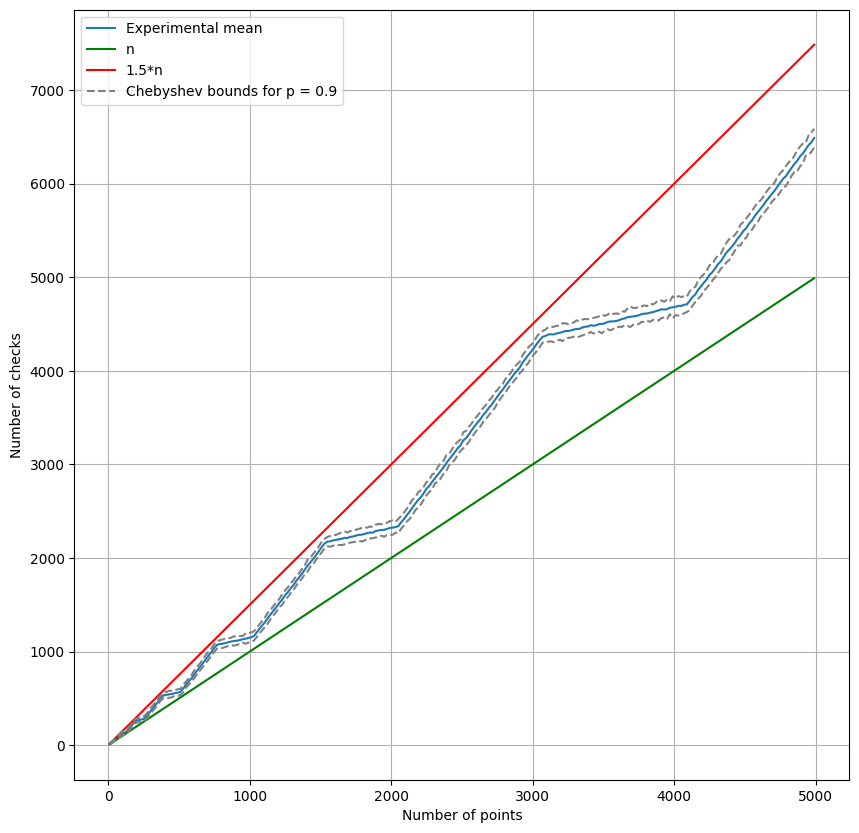

In [274]:
trend_plot(results['y_center_skewed'])

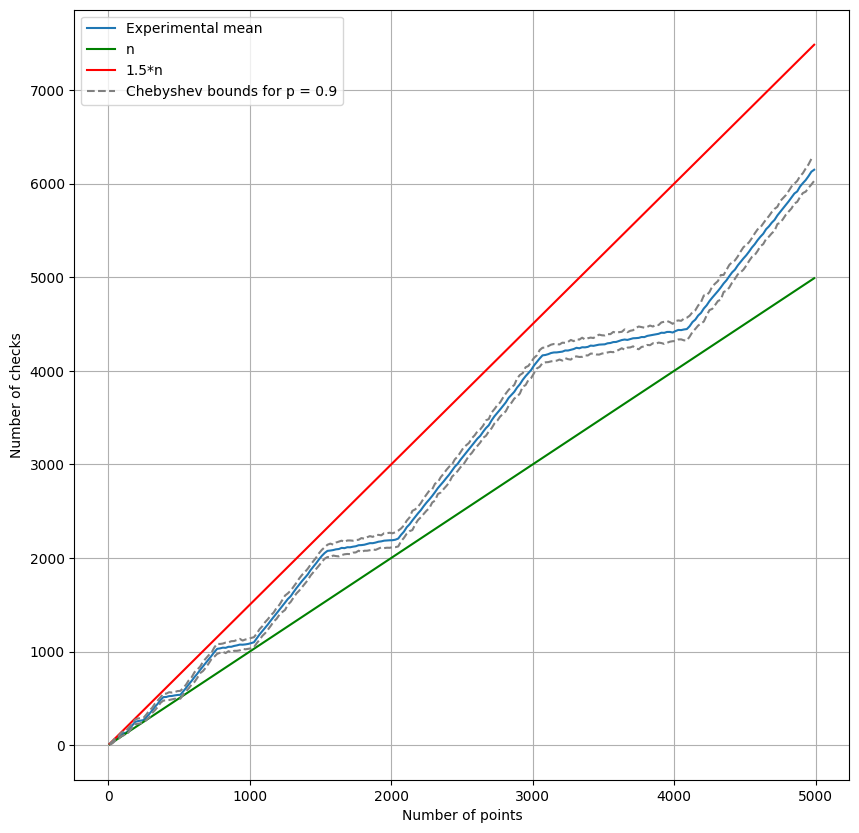

In [275]:
trend_plot(results['x_center_skewed'])

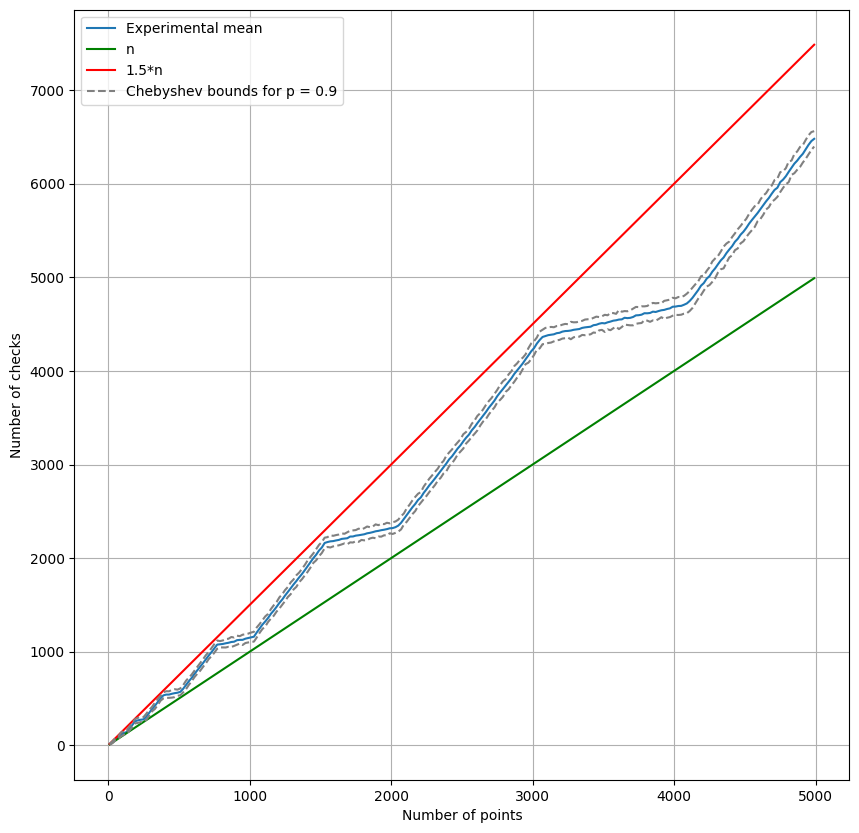

In [276]:
trend_plot(results['y_edge_skewed'])

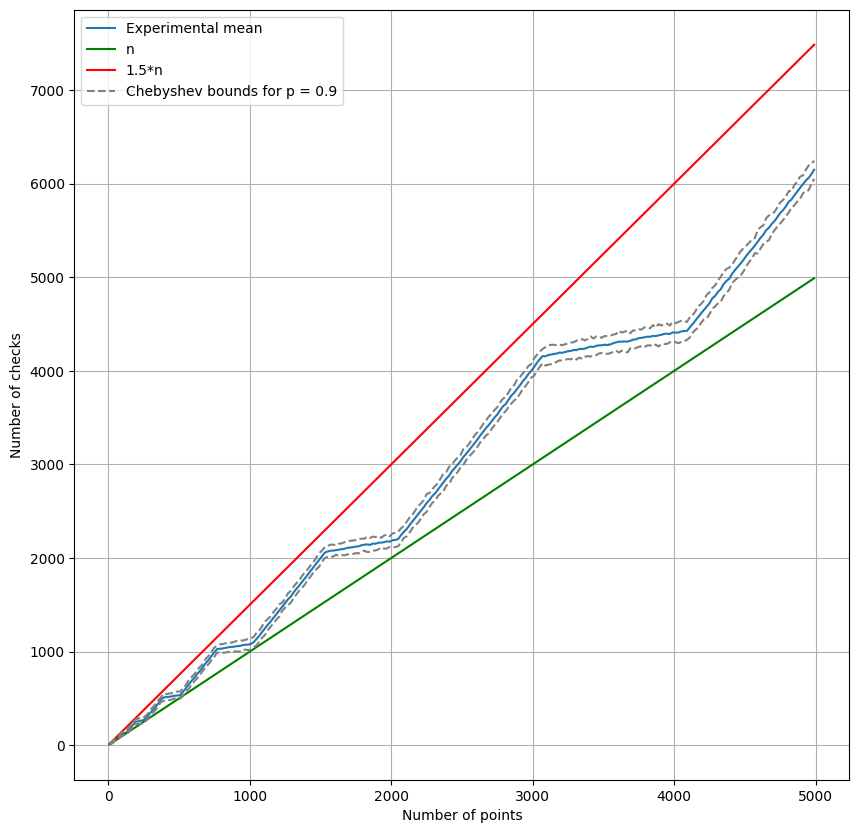

In [277]:
trend_plot(results['x_edge_skewed'])